# Energy usage analysis of meter readings using Pandas
- Load file containg dates and reaings (copied from Ovo site + some entries added by hand). Fairly unstructured format.
- Use regexp to parse these and create a dataframe
- Readings are on random dates so resample to interpolate to daily and plot
- Resample daily to monthly and look at usage per month
- Resample daily to annual and look at usage per year
- Pivot by month and compare year on year usage by month

In [1]:
#imports
import pandas as pd
import numpy as np
import re
import dateparser
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#global plotting styles
sns.set_context('talk')
sns.set_style("darkgrid")

In [3]:
#read the file in
with open('meter_readings.txt') as f:
    raw = f.read()
raw[:100]

'13 Mar 2021You gave121381\n14 Nov 2020You gave117334\n01 Nov 2020You gave116656\n13 Oct 2020You gave115'

In [4]:
#parse into a list of dates and readings
readings = re.findall("(\d\d \w{3} \d{4}).*(\d{6})", raw)
readings[:5]

[('13 Mar 2021', '121381'),
 ('14 Nov 2020', '117334'),
 ('01 Nov 2020', '116656'),
 ('13 Oct 2020', '115792'),
 ('26 Sep 2020', '115113')]

In [5]:
#Convert to dataframe with datetime index
df = pd.DataFrame([(dateparser.parse(d), int(r)) for d,r in readings], columns=['Date', 'Reading'])
df = df.set_index('Date')
df.head()

,Reading
Date,
2021-03-13,121381
2020-11-14,117334
2020-11-01,116656
2020-10-13,115792
2020-09-26,115113


In [6]:
#resample to daily
rng = pd.date_range(df.index.min(), df.index.max())
daily = df.reindex(rng).interpolate(method='time')

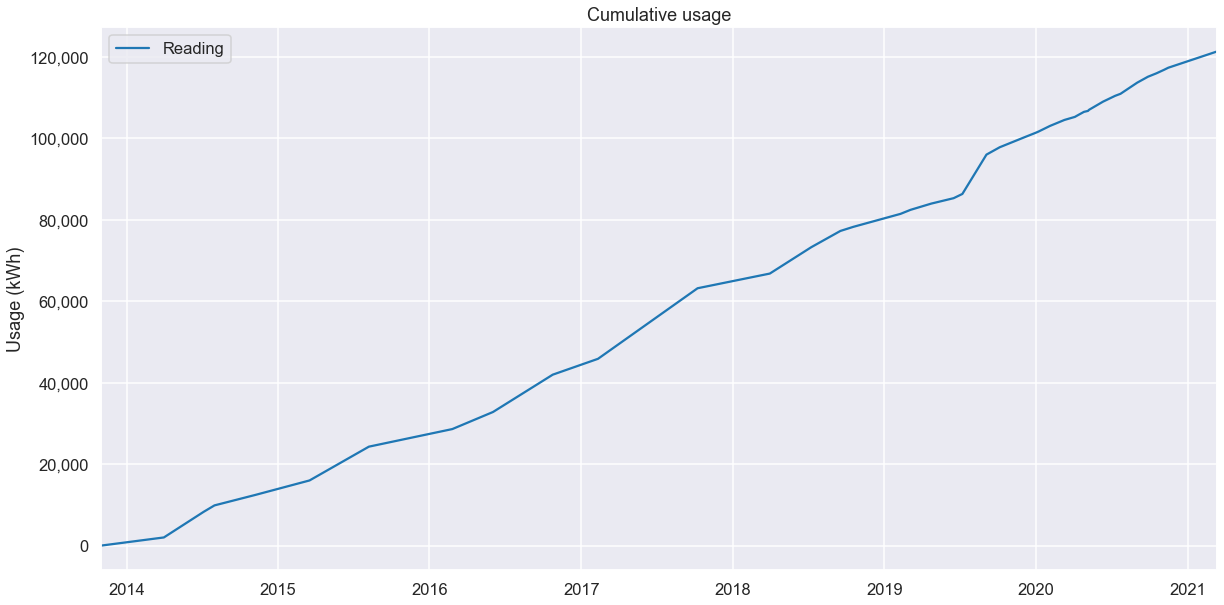

In [7]:
#plot daily series
ax = daily.plot(figsize=(20,10), title = 'Cumulative usage', ylabel='Usage (kWh)')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [8]:
#Resample to monthly
monthly = daily.resample('M').last()
monthly.head()

,Reading
2013-11-30,384.105960
2013-12-31,794.701987
2014-01-31,1205.298013
2014-02-28,1576.158940
2014-03-31,1986.754967


In [9]:
def line_format(date):
    tlm = date.month_name()[:3]
    return f'{date.year} {tlm}' if tlm == 'Jan' else tlm
    

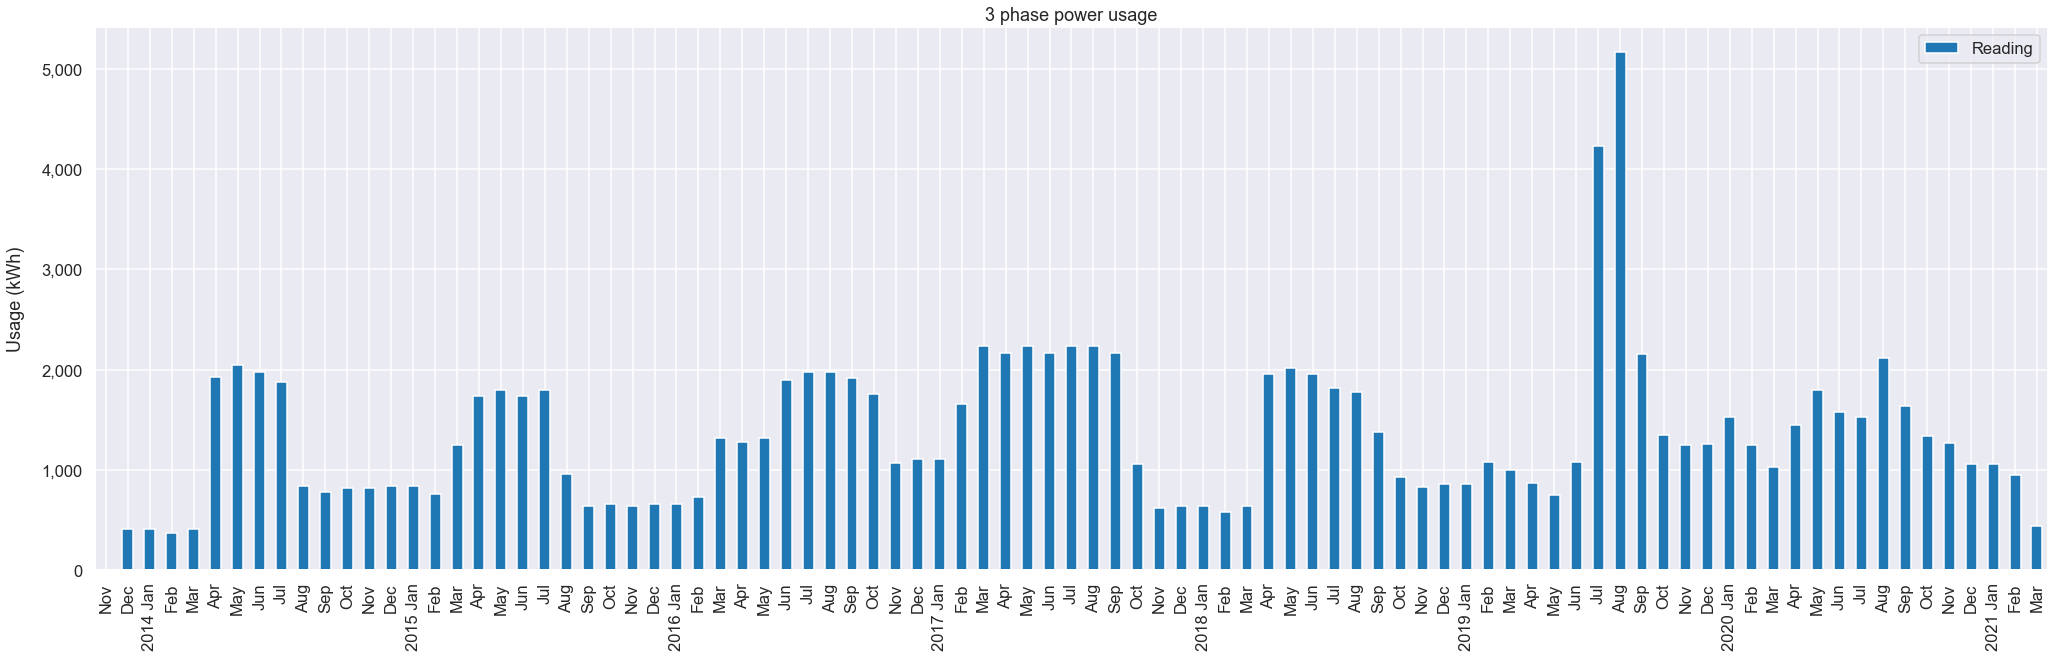

In [10]:
#plot monthly diff (usage by month)
ax = monthly.diff().plot.bar(figsize=(35,10), title='3 phase power usage', grid=True)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Usage (kWh)', labelpad=16)
ax.set_xticklabels(map(line_format, monthly.index));


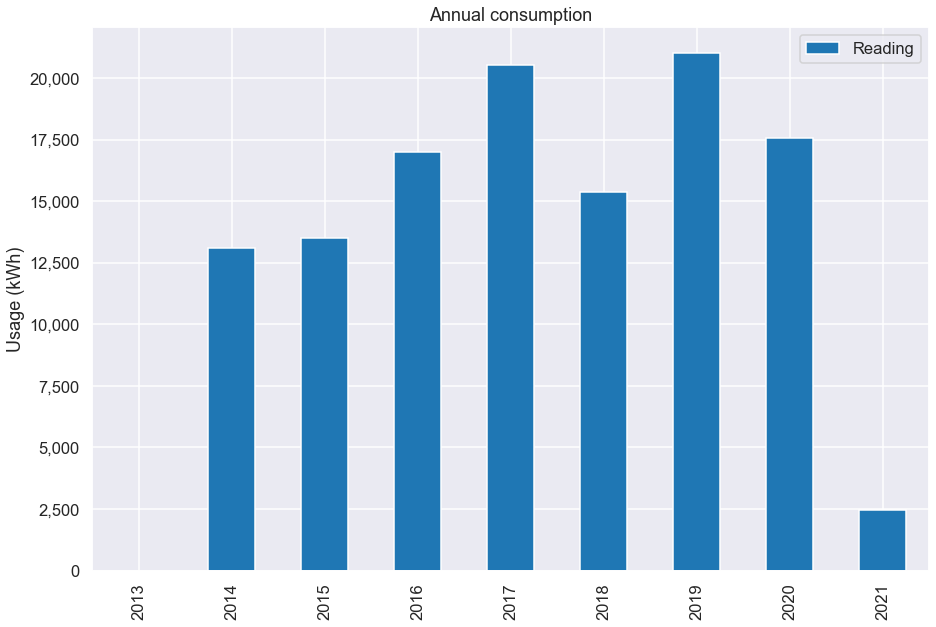

In [11]:
#The same, but for yearly usage
yearly = daily.resample('Y').last().diff()
ax = yearly.plot.bar(title='Annual consumption', figsize=(15,10), ylabel='Usage (kWh)')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticklabels(yearly.index.year);

In [12]:
#Take monthly diff and pivot by month name and year
months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_pivot=pd.pivot_table(monthly.diff(), index=pd.Index([x[:3] for x in monthly.index.month_name()]), columns=monthly.index.year, values="Reading").reindex(months_in_order)
monthly_pivot

,2013,2014,2015,2016,2017,2018,2019,2020,2021
Jan,NaN,410.596026,843.774834,662.935000,1106.981818,642.091954,861.905983,1523.598522,1054.260504
Feb,NaN,370.860927,762.119205,726.046122,1657.140909,579.954023,1074.873932,1251.884236,952.235294
Mar,NaN,410.596026,1244.479229,1319.397959,2238.975000,642.091954,1000.750000,1030.795658,442.109244
Apr,NaN,1925.332945,1741.258741,1276.836735,2166.750000,1954.687500,867.456140,1445.962963,NaN
May,NaN,2043.956044,1799.300699,1319.397959,2238.975000,2019.843750,751.614035,1793.419355,NaN
Jun,NaN,1978.021978,1741.258741,1895.137613,2166.750000,1954.687500,1079.657097,1577.447312,NaN
Jul,NaN,1880.450195,1799.300699,1980.340278,2238.975000,1813.836045,4225.169279,1525.975439,NaN
Aug,NaN,835.483871,956.190664,1980.340278,2238.975000,1774.219178,5162.034483,2115.120858,NaN
Sep,NaN,775.000000,641.550000,1916.458333,2166.750000,1380.837139,2151.423804,1640.801743,NaN
Oct,NaN,818.841060,662.935000,1754.957449,1054.190805,932.350427,1344.472747,1337.761610,NaN


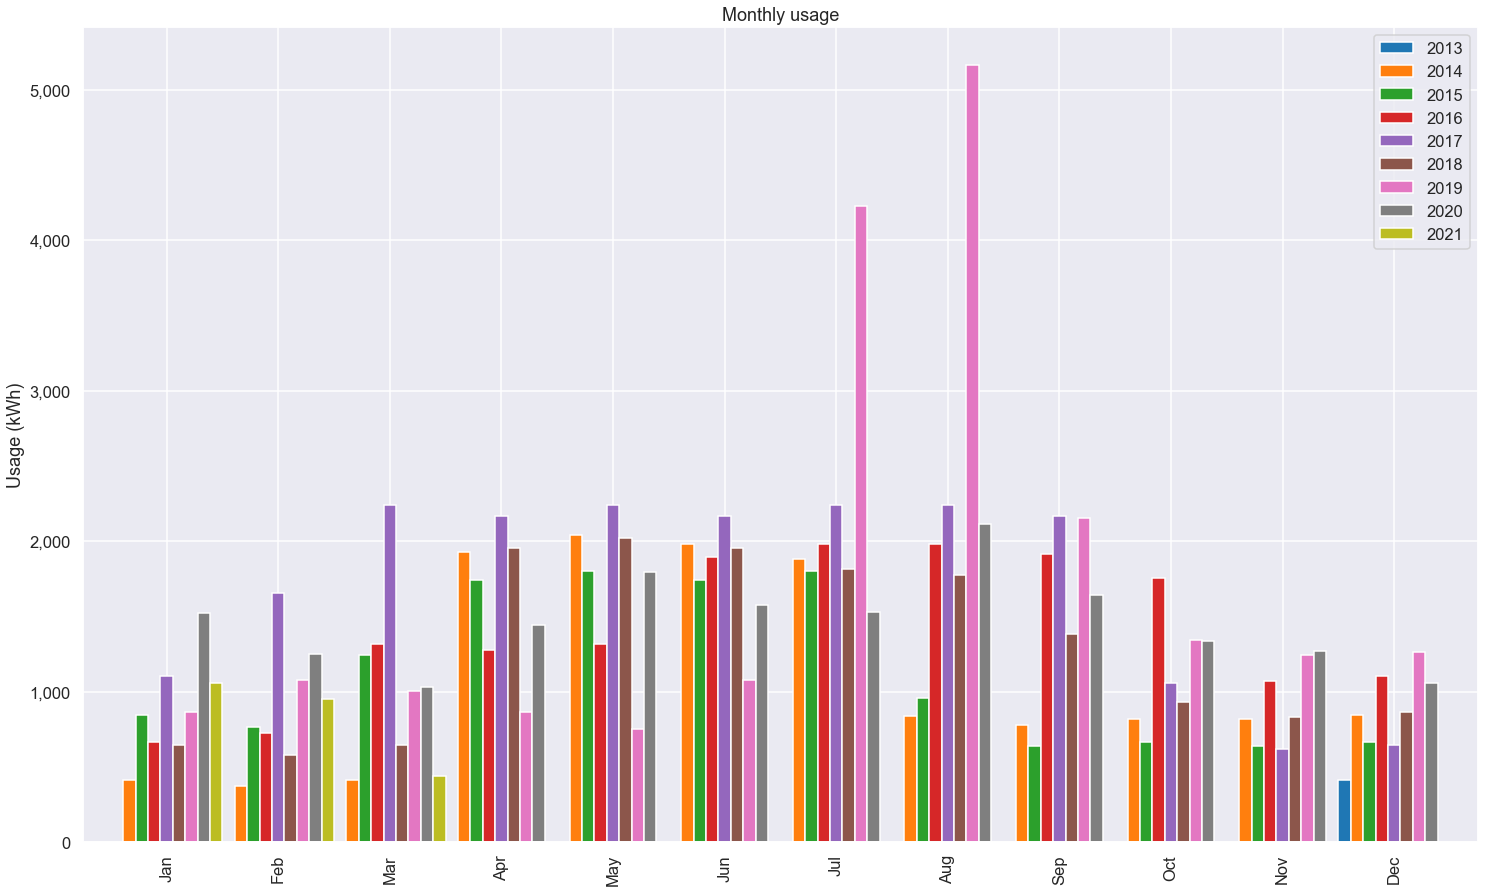

In [13]:
#Plot year on year usage by month
ax = monthly_pivot.plot.bar(figsize=(25,15), width=1, title='Monthly usage', ylabel='Usage (kWh)')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))